# Data exploratory analysis 

### Load modules

In [35]:
# General
import os
import math
import re
from glob import glob

# Data handling
import numpy as np
import pandas as pd

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Image handling
import cv2
import rasterio

In [32]:
import resource

def memory_limit():
    soft, hard = resource.getrlimit(resource.RLIMIT_AS)
    resource.setrlimit(resource.RLIMIT_AS, (get_memory() * 1024 / 2, hard))

def get_memory():
    with open('/proc/meminfo', 'r') as mem:
        free_memory = 0
        for i in mem:
            sline = i.split()
            if str(sline[0]) in ('MemFree:', 'Buffers:', 'Cached:'):
                free_memory += int(sline[1])
    return free_memory

memory_limit()

/tmp/ipykernel_800554/444454138.py:5: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  resource.setrlimit(resource.RLIMIT_AS, (get_memory() * 1024 / 2, hard))


## Load Data

### Load patient data

In [8]:
train_segmentation = pd.read_csv('data/train.csv')
train_segmentation.head(5)

,id,encoding
0,2f6ecfcdf,296084587 4 296115835 6 296115859 14 296147109...
1,8242609fa,96909968 56 96941265 60 96972563 64 97003861 6...
2,aaa6a05cc,30989109 59 31007591 64 31026074 68 31044556 7...
3,cb2d976f4,78144363 5 78179297 15 78214231 25 78249165 35...
4,b9a3865fc,61271840 4 61303134 13 61334428 22 61365722 30...


This csv file links the id of each sample to the ground truth segmentation in a run-length encoding

In [11]:
train_patient_data = pd.read_csv('data/HuBMAP-20-dataset_information.csv')
train_patient_data.head(5)

,image_file,width_pixels,height_pixels,anatomical_structures_segmention_file,glomerulus_segmentation_file,patient_number,race,ethnicity,sex,age,weight_kilograms,height_centimeters,bmi_kg/m^2,laterality,percent_cortex,percent_medulla
0,aa05346ff.tiff,47340,30720,aa05346ff-anatomical-structure.json,aa05346ff.json,67347,White,Not Hispanic or Latino,Female,58,59.0,160.0,23.0,Right,80,20
1,afa5e8098.tiff,43780,36800,afa5e8098-anatomical-structure.json,afa5e8098.json,67347,White,Not Hispanic or Latino,Female,58,59.0,160.0,23.0,Right,55,45
2,54f2eec69.tiff,22240,30440,54f2eec69-anatomical-structure.json,54f2eec69.json,67548,Black or African American,Not Hispanic or Latino,Male,58,79.9,190.5,22.0,Right,75,25
3,d488c759a.tiff,29020,46660,d488c759a-anatomical-structure.json,d488c759a.json,68138,White,Not Hispanic or Latino,Female,66,81.5,158.8,32.2,Left,100,0
4,1e2425f28.tiff,32220,26780,1e2425f28-anatomical-structure.json,1e2425f28.json,63921,White,Not Hispanic or Latino,Male,48,131.5,193.0,35.3,Right,65,35


This dataframe holds infomration about the size of the image as well as data from the patient like heigth, weight, sex, etc. There is some redundant information like the name of the files, that can be derived from the sample id. I will merge this dataframe and train_segmentation. 

In [13]:
# Add a column for the sample id in train_patient_data
train_patient_data['sample_id'] = train_patient_data.image_file.apply(lambda x: x.split('.')[0])

In [23]:
# Merge train_segmentation and train_patient_data using the sample id columns
train = pd.merge(train_segmentation, train_patient_data, left_on='id', right_on='sample_id')

# Remove non desired columns
train = train.drop(['id', 'image_file', 'anatomical_structures_segmention_file',
            'glomerulus_segmentation_file', 'patient_number'], axis=1)

# format column names
train.columns = ['encoding', 'width', 'height', 'race', 'ethnicity', 'sex',
       'age', 'weight', 'height', 'bmi', 'laterality', 'percent_cortex',
                 'percent_medulla', 'sample_id']

### Load images

In [53]:
def load_image(sample_id, out_res=(500,500)):
    
    """Takes a sample id and return the image as a numpy array of shape out_res"""
    
    # Get the path of the image of the smaple
    path = glob(f"data/train/{sample_id}.tiff")[0]
    
    # Load the image
    with rasterio.open(path) as src:        
        sample_image = src.read(out_shape=out_res, resampling=rasterio.enums.Resampling.cubic)
        # Move first chanel axis from the first to the last position and normalize it 
        sample_image = np.moveaxis(sample_image, 0, -1)/255
        
    return sample_image

In [55]:
image = load_image(train.sample_id[0])

/home/adri/anaconda3/envs/hubmap/lib/python3.9/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [57]:
image.shape

(500, 500, 3)

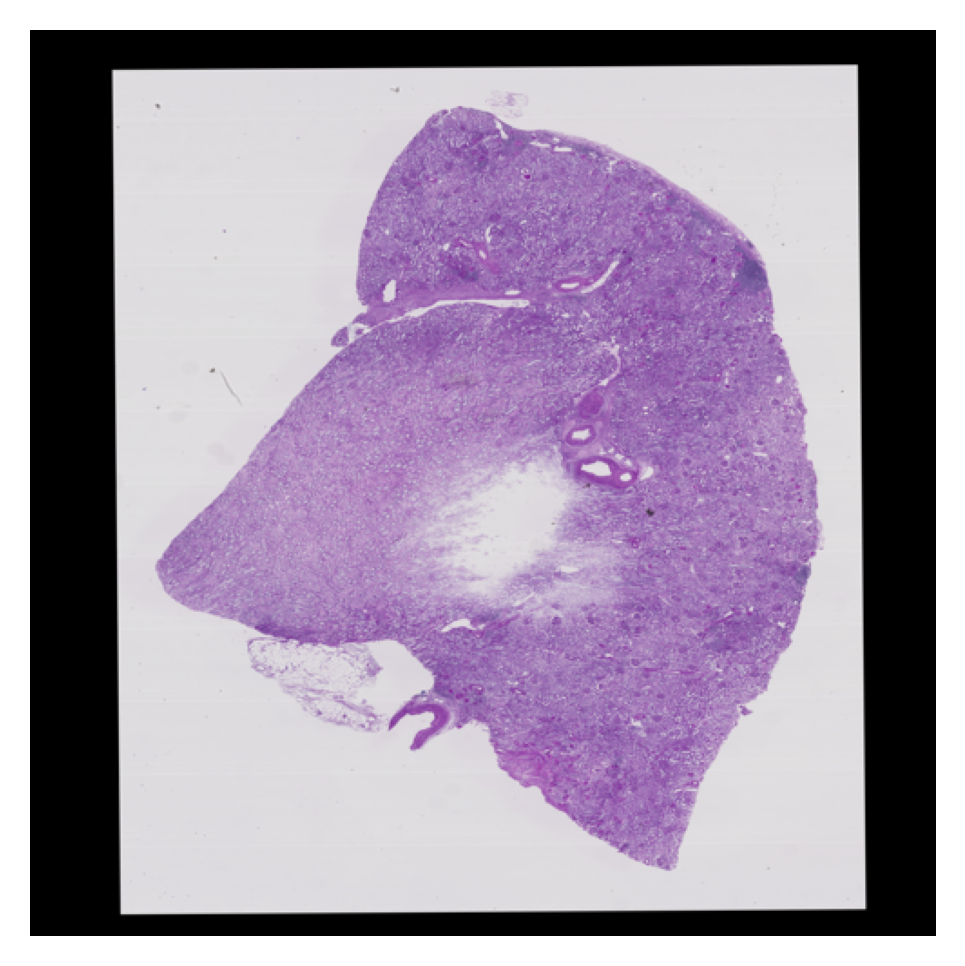

In [56]:
plt.figure(dpi=300)
plt.imshow(image)
plt.axis('off')
plt.show()